# Getting the CLF Dataset 

In [2]:
#!/usr/bin/env python

import matplotlib.pyplot as plt
import numpy as np

with open('intel.clf', 'r') as f:
   lasers = []
   odoms = []
   for line in f:
       tokens = line.split(' ')
       if tokens[0] == 'FLASER':
           num_readings = int(tokens[1])
           scans = np.array(tokens[2:2+num_readings], dtype=np.float)
           scan_time = float(tokens[2+num_readings+6])
           index = np.arange(-90, 90+180/num_readings, 180/num_readings)
           index = np.delete(index, num_readings//2)
           converted_scans = []
           angles = np.radians(index)
           converted_scans = np.array([np.cos(angles), np.sin(angles)]).T * scans[:, np.newaxis]
           lasers.append(np.array(converted_scans))
           x = float(tokens[2+num_readings])
           y = float(tokens[3+num_readings])
           theta = float(tokens[4+num_readings])
           odoms.append([x, y, theta])

odoms = np.array(odoms)
lasers = np.array(lasers)


<ipython-input-2-0c358d04d62c>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scans = np.array(tokens[2:2+num_readings], dtype=np.float)


# Plotting raw odometry values

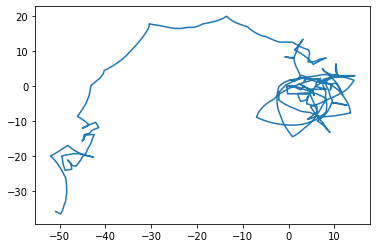

In [3]:
plt.plot(odoms[:,0],odoms[:,1]) # x and y value

# Getting a set of laser scan values

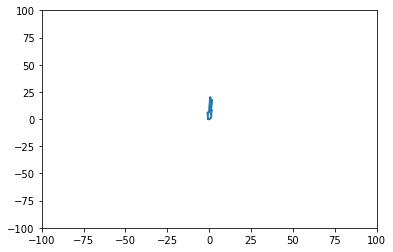

In [10]:
from matplotlib import animation
fig = plt.figure()

lasers_cart_x = np.zeros((180,))
lasers_cart_y = np.zeros((180,)) 
#scat = plt.scatter(lasers_cart_x,lasers_cart_y)
ax = plt.axes(xlim=(-5,5),ylim=(-1,30))
line, = ax.plot([], [], lw=2)
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(k):
  for i in range(len(lasers[k, : ,0])):
    lasers_cart_y[i] = lasers[k, i, 0]*np.sin(np.radians(i))
    lasers_cart_x[i] = lasers[k, i, 0]*np.cos(np.radians(i))
  line.set_data(lasers_cart_x,lasers_cart_y)
  return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=20, blit=True)
writergif = animation.PillowWriter(fps=30)
anim.save('filename.gif',writer=writergif)

plt.show()

# Extracting Features

In [13]:
import math
from fraction import Fraction
from scipy.odr import *

In [ ]:
class featuresDetection:
    def __init__(self):
        self.EPSILON = 10
        self.DELTA = 501
        self.SNUM = 6
        self.PMIN = 20
        self.GMAX = 20
        self.SEED_SEGMENTS = []
        self.LINE_SEGMENTS = []
        self.LASERPOINTS = []
        self.LINE_PARAMS = None
        self.NP = len(self.LASERPOINTS) - 1
        self.LMIN = 20
        self.LR = 0
        self.PR = 0
        
    #Function to check the euclidean distance between two points
    def dist_point2point(self, point1,point2):
        Px = (point1[0]-point2[0])**2
        Py = (point1[1]-point2[1])**2
        return math.sqrt(Px + Py)
    
    #Function to check the distance between a point and a line with the line in the form Ax+By=C
    def dist_point2line(self, params, point):
        A,B, C = params
        distance =abs(A*point[0] + B*point[1]+ C)/math.sqrt(A**2 + B**2)
        return distance
    #Function to get to points from a line in form y = mx+b
    def line_2point(self,m,b):
        x = 5;
        y = m*x+b
        x2 = 2000
        y2 = m*x2+b
        return [(x,y),(x2,y2)]
    
    #Function to convert from a Ax+By=C to y = mx +b
    def line_G2SI(self, A, B, C):
        m = -A/B
        b = -C/B
        return m,b
    
    #Function that converts from the slope intercept to general form 
    def line_SI2G(self, m, B):
        A,B,C = -m, 1, -B
        if A < 0:
            A,B,C = -A, -B,-C
        den_a = Fraction(A).limit_denominator(1000).as_integer_ratio()[1]
        den_c = Fraction(C).limit_denominator(1000).as_integer_ratio()[1]
        
        gcd = np.gcd(den_a,den_c)
        lcm = den_a*den_c /gcd
        
        A = A*lcm
        B = B*lcm
        C = C*lcm
        
        return A, B, C
    
    #Function to find the point of intersection of two lines 
    #Note the two lines are assumed to intersect beforehand
    def line_intersect_general(self,params1,params2):
        a1,b1,c1 = params1
        a2,b2,c2 = params2
        x = (c1*b2-b1*c2)/(b1*a2-a1*b2)
        y = (a1*c2-a2*c1)/(b1*a2-a1*b2)
        return x,y
    
    #Function to extract the si equation of a line that passes through two given points
    def points_2line(self, point1,point2):
        m,b=0,0
        if point2[0]==point1[0]:
            pass
        else:
            m = (point2[1]-point1[1])/(point2[0]-point1[0])
            b = point2[1] - m*point2[0]
        return m,b
    
    #Function that returns a projection of a point to a line as a tuple
    def projection_point2line(self , point,m, b):
        x, y =point
        m2 = -1/m
        c2 = y-m2*x
        intersection_x = -(b-c2)/(m-m2)
        intersection_y = m2*intersection_x+c2
        return intersection_x, intersection_y
    
    #Function to convert from Polar to Cartesian
    def pol2cart(self, distance,angle,robot_position):
        x = distance * math.cos(angle) + robot_position[0]
        y = -distance*math.sin(angle) +robot_position[1]
        return(int(x),int(y))
    
    